## Analyzing an audio signal using short-time Fourier transform

In [90]:
import soundfile as sf   # We use this one to read and write sound file
import math # basic math functions
import io # We use this one for basic file input/output operations
import numpy as np   # We use this one to do numerical operations
import scipy.fftpack as fftpack # We use this one to perform Fourier transforms
import urllib.request as request  # We use this one to get things from the web
import matplotlib.pyplot as plt  # We use this one to plot things
import matplotlib as mpl
from scipy import signal
import librosa
# The next line causes matplotlib to put its plots in this webpage.  That's reasonable for small spectrograms, maybe less than one second.

# General plot parameters
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.linestyle'] = '-'

mpl.rcParams['font.family'] = 'DejaVu Sans' # this is also the default
mpl.rcParams['font.size'] = 14

mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# stating multiple params in one line
mpl.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha": 0.3, "grid.linestyle": "--"})

%matplotlib inline

# Plotting a waveform
The first thing we want is to load an audio signal. You can record your own audio signal or use the one (audio_sample.wav) provided in the course website.

In [91]:
file_name = 'audio_sample.wav'
data, fs = sf.read(file_name)
print(f'Sampling rate: {fs} Hz')
print('Shape of audio data:', data.shape)
nsamples = data.shape[0]
nchan = data.shape[1]

Sampling rate: 44100 Hz
Shape of audio data: (386560, 2)


Note that the data sample count is 386560 samples and there are two channels. An audio signal with two channels is referred to as stereo audio. One channel feeds to the left ear and the other two the right ear. Given the sampling rate of the signal, the duration is `nsamples x 1/fs`. Let's plot the time domain data.

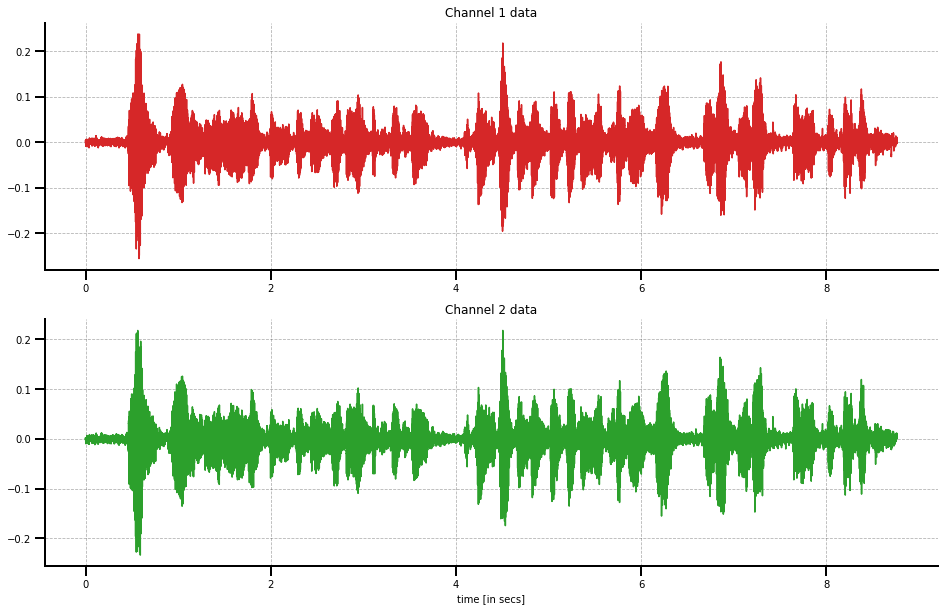

In [92]:
t = np.arange(0, nsamples,1)/fs

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10))
ax[0].plot(t, data[:,0], c='tab:red')
ax[0].set_title('Channel 1 data')
ax[1].plot(t, data[:,1], c='tab:green')
ax[1].set_xlabel('time [in secs]')
ax[1].set_title('Channel 2 data')
plt.show()

As you can notice, the two waveforms appear very similar. If we zoom inside there will be minor difference between the two signals. We will proceed by analyzing the signal in one channel (first channel).

In [93]:
data_left = data[:,0]
data_right = data[:,1]


The signal is close to 8 secs in duration. Let's introduce the concept of chunking the audio signal into overlapping temporal segments.

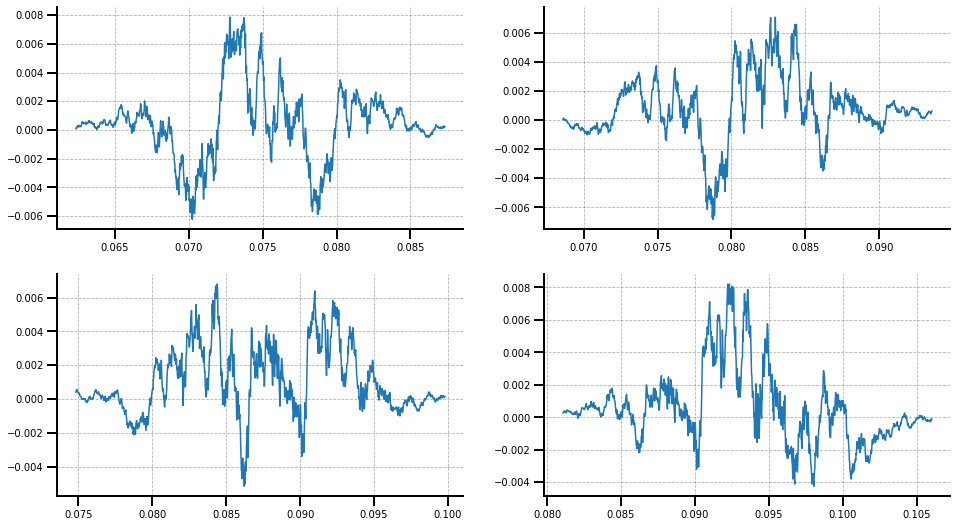

In [94]:
def enframe(x, S, L):
    '''
    x: signal
    S: window shift (in samples)
    L: window length (in samples)
    output: a list containing chunked audio segments
    
    '''
    w = np.hamming(L) # window function to tapper the edges
    frames = []
    indices = []
    nframes = 1+int((len(x)-L)/S)
    for t in range(0, nframes):
        frames.append(x[t*S:t*S+L] * w)
        indices.append(np.arange(t*S, t*S+L))
    return(frames, indices)

w_dur = 25e-3 # window duration in milli-secs
shift_dur = w_dur/4 # shift or hop duration in milli-secs

frames, indices = enframe(data_left, int(shift_dur*fs), int(w_dur*fs))

# visualizing four consecutive signal frames - note the overlap in time axis (and hence, signals) across these plots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[16,9])
frame_id = 10
ax[0,0].plot(indices[frame_id] * 1/fs, frames[frame_id])
ax[0,1].plot(indices[frame_id+1] * 1/fs, frames[frame_id+1])
ax[1,0].plot(indices[frame_id+2] * 1/fs, frames[frame_id+2])
ax[1,1].plot(indices[frame_id+3] * 1/fs, frames[frame_id+3])
plt.show()

## Short-time Fourier Analysis
The next idea is to compute DFT of these chunks of audio and collect the DFTs into a list. Below is the `stft()` which does this.

In [95]:
def stft(frames, N):
    '''
    frames: contains chuncks of audio
    N: length for DFT computation
    stft_frames: returns stft frames
    '''
    stft_frames = [fftpack.fft(x,N) for x in frames]
    return(stft_frames)

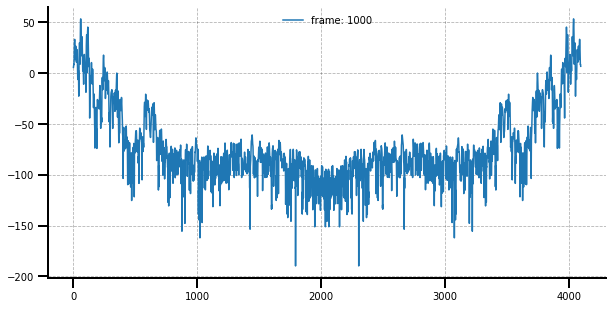

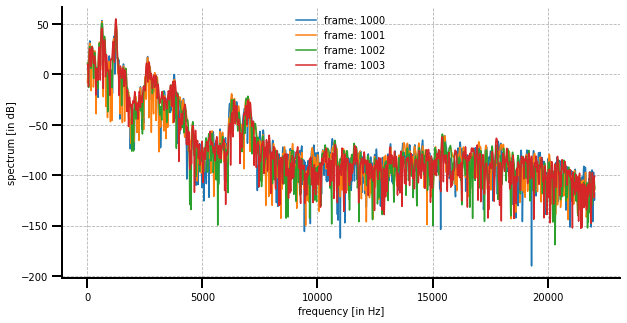

In [106]:
nfft = 4096

stft_frames = stft(frames, nfft)

# visualizing four consecutive signal frames - note the overlap in time axis (and hence, signals) across these plots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,5])
frame_id = 1000
for indx in range(1):
    ax.plot(20*np.log(abs(stft_frames[frame_id+indx] + 1e-10)), label='frame: '+str(frame_id+indx))

plt.legend(frameon=False, loc='upper center')
plt.show()

# We know the DFT spectrum is mirror symmeteric over [0, nnft]
# We plot the spectrum over only [0,nfft//2] and also label the tick marks to show the exact frequencies
indices = np.arange(0, nfft//2+1)
faxis =  indices /nfft * fs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,5])
frame_id = 1000
for indx in range(4):
    ax.plot(faxis, 20*np.log(abs(stft_frames[frame_id+indx][indices] + 1e-10)), label='frame: '+str(frame_id+indx))
ax.legend(frameon=False, loc='upper center')
ax.set_ylabel('spectrum [in dB]')
ax.set_xlabel('frequency [in Hz]')
plt.legend(frameon=False, loc='upper center')
plt.show()


## Observations
The maximum energy is close to 50 dB (around 1000 Hz). After 10000 Hz, the spectral energy is below 50 dB. This indicates very low energy above this frequency.
 

In [107]:
# fs_rs = 16000
# data_left_rs = librosa.resample(data_left, fs, fs_rs)
# data_right_rs = librosa.resample(data_right, fs, fs_rs)


In [108]:
def stft2level(stft_spectra,max_freq_bin):
    magnitude_spectra = [ abs(x) for x in stft_spectra ]
    max_magnitude = max([ max(x) for x in magnitude_spectra ])
    min_magnitude = max_magnitude / 1000.0
    for t in range(0,len(magnitude_spectra)):
        for k in range(0,len(magnitude_spectra[t])):
            magnitude_spectra[t][k] /= min_magnitude
            if magnitude_spectra[t][k] < 1:
                magnitude_spectra[t][k] = 1
    level_spectra = [ 20*np.log10(x[0:max_freq_bin]) for x in magnitude_spectra ]
    return(level_spectra)

44100


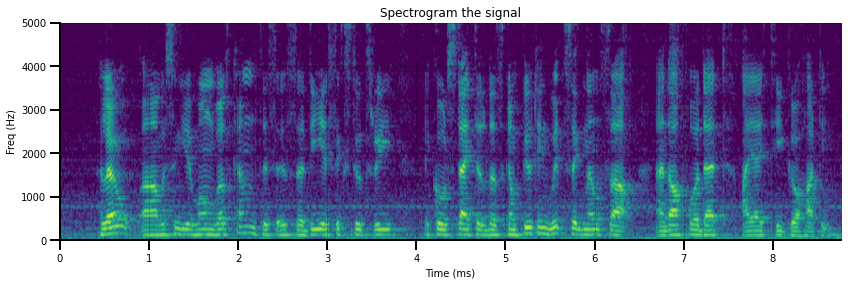

In [109]:
max_freq = 5000 # choose 5000Hz as the maximum displayed frequency
sgram = stft2level(stft_frames, int(nfft*max_freq/fs))
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(np.array(sgram)),origin='lower',extent=(0,t[-1],0,max_freq),aspect='auto')
plt.title('Spectrogram the signal')
plt.xlabel('Time (ms)')
plt.ylabel('Freq (Hz)')
print(fs)

## Wrapping above into one function
Below we create a function `sgram()` which contains the above function.

In [114]:
def sgram(x, frame_shift, frame_length, fft_length, fs, max_freq):
    frames = enframe(x, frame_shift, frame_length)
    (spectra, freq_axis) = stft(frames, fft_length)
    sgram = stft2level(spectra, int(max_freq*fft_length/fs))
    max_time = len(frames)*frame_shift/fs
    return(sgram, max_time, max_freq)

Text(0, 0.5, 'Frequency (Hz)')

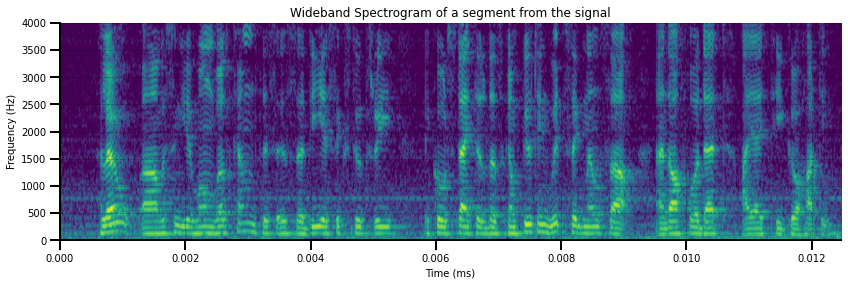

In [116]:
w_dur = 25e-3 # window duration in milli-secs
shift_dur = w_dur/4 # shift or hop duration in milli-secs
nfft = 4096
max_freq = 4000
(narrowband_sgram, w_maxtime, w_maxfreq) = sgram(data_left, int(shift_dur * fs), int(w_dur * fs), nfft, fs, max_freq)  
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(np.array(narrowband_sgram)),origin='lower',extent=(0,w_maxtime,0,w_maxfreq),aspect='auto')
plt.title('Wideband Spectrogram of a segment from the signal')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

# Reducing frequency resolution and increasing time resolution
Decreasing the time window will decrease frequeny resolution and increase the time resolution in the spectrogram.

Text(0, 0.5, 'Frequency (Hz)')

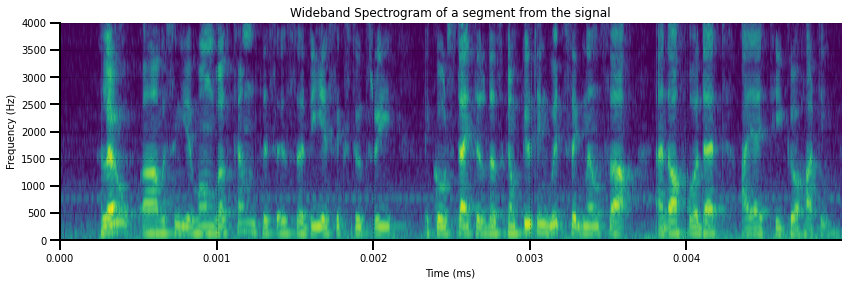

In [117]:
w_dur = 10e-3 # window duration in milli-secs
shift_dur = w_dur/4 # shift or hop duration in milli-secs
nfft = 4096
(wideband_sgram, w_maxtime, w_maxfreq) = sgram(data_left, int(shift_dur * fs), int(w_dur * fs), nfft, fs, max_freq)  
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(np.array(wideband_sgram)),origin='lower',extent=(0,w_maxtime,0,w_maxfreq),aspect='auto')
plt.title('Wideband Spectrogram of a segment from the signal')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.show()